<h1>Convolution Neural Network Application</h1>

<h2>Import Dependencies</h2>

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import torch
from cnn_utils import *

In [2]:
np.random.seed(1)

<h2>Load Dataset</h2>

In [138]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_happy_dataset()

In [139]:
# normalize data

train_X_orig = train_set_x_orig / 255.
test_X_orig = test_set_x_orig / 255.
train_Y_orig = train_set_y_orig.T
test_Y_orig = test_set_y_orig.T

In [329]:
# check the dataset
print(f'training data shape: {train_X_orig.shape}')
print(f'test data shape: {test_X_orig.shape}')
print(f'training label shape: {train_Y_orig.shape}')
print(f'test label shape: {test_Y_orig.shape}')
print(f'image pixel: {train_X_orig.shape[1]}')
print(f'training sample num: {train_X_orig.shape[0]}')
print(f'test sample num: {test_X_orig.shape[0]}')
print(f'classes num: {len(classes)}')

training data shape: (600, 64, 64, 3)
test data shape: (150, 64, 64, 3)
training label shape: (600, 1)
test label shape: (150, 1)
image pixel: 64
training sample num: 600
test sample num: 150
classes num: 2


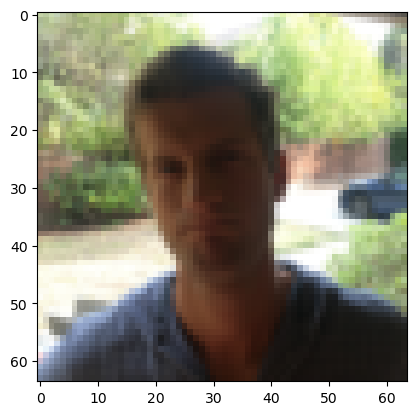

In [141]:
# display an image
index = 10
plt.imshow(train_set_x_orig[index])
plt.show()

<h2>Sequential Model</h2>

In [209]:
class happyModel(torch.nn.Module):
    '''
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Args:
    None

    Returns:
    model -- Pytorch model
    '''
    
    def __init__(self):
        super(happyModel, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.ZeroPad2d((3,3,3,3)),
            torch.nn.Conv2d(3,32,kernel_size=7,stride=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(32*32*32, 1),
            torch.nn.Sigmoid()
        )
    
    
    def forward(self, x):
        logits = self.model(x)
        return logits
    

In [210]:
# check the model
happy_model = happyModel()

In [336]:
# define loss function and optimizer

loss = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(happy_model.parameters(), lr=learning_rate)

In [212]:
# check available device

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [278]:
# cast data type
print(train_X_orig.dtype)
print(train_Y_orig.dtype)
print(test_X_orig.dtype)
print(test_Y_orig.dtype)
print('----------------------------')
train_X_orig = train_X_orig.astype('float32')
train_Y_orig = train_Y_orig.astype('int64')
test_X_orig = test_X_orig.astype('float32')
test_Y_orig = test_Y_orig.astype('int64')
print(train_X_orig.dtype)
print(train_Y_orig.dtype)
print(test_X_orig.dtype)
print(test_Y_orig.dtype)

float32
int64
float32
int64
----------------------------
float32
int64
float32
int64


In [234]:
# reshape data to Pytorch compatible

print(f'origin data shape: {train_X_orig.shape}')
print(f'origin label shape: {train_Y_orig.shape}')
train_X = np.reshape(train_X_orig, (train_X_orig.shape[0], train_X_orig.shape[3], train_X_orig.shape[1], train_X_orig.shape[2]))
#train_Y = np.reshape(train_Y_orig, (train_X_orig.shape[0],))
print(f'modify data shape: {train_X.shape}')
print(f'modify label shape: {train_Y.shape}')

origin data shape: (600, 64, 64, 3)
origin label shape: (600, 1)
modify data shape: (600, 3, 64, 64)
modify label shape: (600,)


In [215]:
# reshape data to Pytorch compatible

print(f'origin data shape: {test_X_orig.shape}')
print(f'origin label shape: {test_Y_orig.shape}')
test_X = np.reshape(test_X_orig, (test_X_orig.shape[0], test_X_orig.shape[3], test_X_orig.shape[1], test_X_orig.shape[2]))
test_Y = np.reshape(test_Y_orig, (test_X_orig.shape[0],))
print(f'modify data shape: {test_X.shape}')
print(f'modify label shape: {test_Y.shape}')

origin data shape: (150, 64, 64, 3)
origin label shape: (150, 1)
modify data shape: (150, 3, 64, 64)
modify label shape: (150,)


In [337]:
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_Y))
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=batch_size)

In [338]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        pred = torch.reshape(pred, (pred.shape[0],))
        loss = loss_fn(pred, y.type(torch.float32))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f'train loss: {loss}')

In [339]:
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_X), torch.from_numpy(test_Y))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [348]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            print(X.shape)
            print(y.shape)
            pred = torch.reshape(pred, (pred.shape[0],))
            test_loss += loss_fn(pred, y.type(torch.float32)).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    
    print(f'Acc: {100 * correct} Avg Loss: {test_loss}')

In [349]:
epochs = 10

for e in range(epochs):
    print(f'Epoch {e + 1}')
    train(train_dataloader, happy_model, loss, optimizer)
    test(test_dataloader, happy_model, loss)

Epoch 1
train loss: 65.84898376464844
train loss: 62.38324737548828
train loss: 72.78045654296875
train loss: 62.38324737548828
train loss: 58.917510986328125
train loss: 45.0545654296875
train loss: 58.917510986328125
train loss: 51.98604202270508
train loss: 48.52030563354492
train loss: 51.98603820800781
train loss: 51.98604202270508
train loss: 41.588829040527344
train loss: 38.12309646606445
train loss: 62.38324737548828
train loss: 51.98604202270508
train loss: 55.45177459716797
train loss: 48.52030563354492
train loss: 65.84898376464844
train loss: 41.314697265625
torch.Size([32, 3, 64, 64])
torch.Size([32])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)